# Plant Seedlings Classification
## Determine the species of a seedling from an image

1. Choosing learning rate
1. Data augmentation



1. recompute=True
1. Use lr_find() to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use lr_find() again
1. Train full network with cycle_mult=2 until over-fitting

In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
sys.path.append('../')

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/max/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/max/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/max/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
PATH = "../../../data/plant_seeding_clf/"
sz=224

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.backends.cudnn.enabled

True

In [8]:
os.listdir(PATH)

['train', 'sample_submission.csv', 'test', 'valid']

In [15]:
folders = os.listdir(f'{PATH}train')
folders

['Scentless Mayweed',
 'Loose Silky-bent',
 'Sugar beet',
 'Charlock',
 'Shepherds Purse',
 'Cleavers',
 'Small-flowered Cranesbill',
 'Black-grass',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Maize']

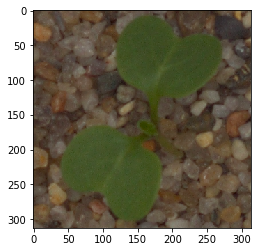

In [9]:
files = os.listdir(f'{PATH}test')
img = plt.imread(f'{PATH}test/{files[0]}')
plt.imshow(img);

In [10]:
def copy_or_move_with_subdirs(subdir_lst, src, dst, r, move=False):
    do = shutil.move if move else shutil.copy
    for subdir in subdir_lst:
        os.makedirs(os.path.join(dst, subdir))
        files = glob(os.path.join(src, subdir, '*'))
        np.random.shuffle(files)
        for f in files[:int(len(files) * r)]:
            do(f, os.path.join(dst, subdir, os.path.split(f)[1]))

In [17]:
def create_val(path, folders, r):
    """ Takes a path to a dataset and creates a validation set of specified size

    Note - this changes the dataset at <path> by moving files to the val set

    Parameters:
    -----------
    path: dataset path
    r (float): proportion of examples to use for validation, in the range from 0 to 1

    """
    val_path = os.path.join(os.path.split(path)[0], 'valid')
    dump_path = os.path.join(os.path.split(path)[0], 'dump')
    subdirs = [os.path.split(p)[1] for p in glob(os.path.join(path + 'train/', '*'))]
    # in prod need set move=True
    copy_or_move_with_subdirs(subdirs, path + 'train/', dump_path, r, move=False)
    copy_or_move_with_subdirs(subdirs, path + 'train/', val_path, r, move=True)

In [18]:
if not os.path.isdir(f'{PATH}valid'):
    print('Create valid data set')
    create_val(f'{PATH}', folders, 0.2)

Create valid data set


In [21]:
#TODO: here need check mulival clf
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

RuntimeError: cuda runtime error (35) : CUDA driver version is insufficient for CUDA runtime version at /home/max/Documents/Projects.githab/fastai/pytorch/torch/lib/THC/THCGeneral.c:70

In [19]:
img.shape

(313, 313, 3)

In [22]:
data.val_y

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3

In [23]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [24]:
log_preds = learn.predict()
log_preds.shape

NameError: name 'learn' is not defined

Select lern rate

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

In [ ]:
Augmentation transform

In [ ]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [ ]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [ ]:
ims = np.stack([get_augs() for i in range(6)])

In [ ]:
plots(ims, rows=2)

In [ ]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
learn.fit(1e-2, 1)

In [ ]:
learn.precompute=False

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('224_lastlayer')

In [ ]:
learn.load('224_lastlayer')

### Fine-tuning and differential learning rate annealing

In [25]:
learn.unfreeze()

NameError: name 'learn' is not defined

In [ ]:
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [26]:
learn.sched.plot_lr()

NameError: name 'learn' is not defined

In [27]:
learn.save('224_all')

NameError: name 'learn' is not defined

In [ ]:
learn.load('224_all')

In [28]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

NameError: name 'learn' is not defined

In [ ]:
accuracy_np(probs, y)